In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('car_gn_cluster2.csv')
df.head(2)

,date,days,road_name,link_id,start_point,end_point,direction,road_length,road_num,road_type,...,d4_length,d4_num,victims_length,victims_num,severity_length,severity_num,accident_count_length,accident_count_num,month,season
0,20180101,월,강남대로,1220021100,우성아파트,강남역,상행,586,5.0,주간선도로,...,0.047782,1.866667,0.74744,29.2,2.192833,85.666667,0.477816,18.666667,1,3
1,20180101,월,강남대로,1220021100,우성아파트,강남역,상행,586,5.0,주간선도로,...,0.047782,1.866667,0.74744,29.2,2.192833,85.666667,0.477816,18.666667,1,3


In [14]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["days"] = lb_make.fit_transform(df["days"])
df["direction"] = lb_make.fit_transform(df["direction"])
df["road_type"] = lb_make.fit_transform(df["road_type"])
df["urban_suburb"] = lb_make.fit_transform(df["urban_suburb"])
df["district"] = lb_make.fit_transform(df["district"])
df["time"] = lb_make.fit_transform(df["time"])

In [15]:
cols = ['days','time','road_type','month','temp_level','rain_level','dust_PM10_level',
       'dust_PM2_level', 'rain_level', 'wind_level', 'O3_level','severity_level']

df_dummy = pd.get_dummies(df, columns=cols)
df = pd.concat([df_dummy, df[cols]], axis = 1)

In [16]:
df.drop(['cluster','district'],axis = 1,inplace=True)
df.head(2)

,date,road_name,link_id,start_point,end_point,direction,road_length,road_num,urban_suburb,value,...,road_type,month,temp_level,rain_level,dust_PM10_level,dust_PM2_level,rain_level,wind_level,O3_level,severity_level
0,20180101,강남대로,1220021100,우성아파트,강남역,0,586,5.0,0,26.95,...,1,1,1,0,1,1,0,0,0,2
1,20180101,강남대로,1220021100,우성아파트,강남역,0,586,5.0,0,26.10,...,1,1,1,0,1,1,0,0,0,2


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['date','road_name','link_id','start_point','end_point','value'],axis = 1), df['value'], test_size=0.3, random_state=333)

In [18]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [19]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred) : 
    return np.sqrt(mean_squared_error(y_true, y_pred))

def model_cv_test(model, train_X, train_y, test_X, test_y, is_log) :

    train_rmse = []
    valid_rmse = []
    
    print('##### {} #####'.format(model.__class__.__name__))
        
    for i, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        X_train, X_val = train_X.iloc[train_idx, :], train_X.iloc[val_idx, :]
        y_train, y_val = train_y[train_idx], train_y[val_idx]

        model.fit(X_train, y_train)
        
        if is_log :
            y_train = np.expm1(y_train)
            y_val = np.expm1(y_val)
            pred_train = np.expm1(model.predict(X_train))
            pred_valid = np.expm1(model.predict(X_val))
        else :
            pred_train = model.predict(X_train)
            pred_valid = model.predict(X_val)

        print('{0} fold train rmse : {1:.3f} valid rmse : {2:.3f}'.format(i, rmse(y_train, pred_train), rmse(y_val, pred_valid)))
        
        train_rmse.append(rmse(y_train, pred_train))
        valid_rmse.append(rmse(y_val, pred_valid))

    print('\n')    
    print('mean train rmse : {0:.3f} mean valid rmse : {1:.3f}'.format(np.mean(train_rmse), np.mean(valid_rmse)))

    
    model.fit(train_X, train_y)
    
    if is_log :
        test_y = np.expm1(test_y)
        pred_test = np.expm1(model.predict(test_X))
    else :
        pred_test = model.predict(test_X)
    
    print('test rmse {0:.3f} '.format(rmse(test_y, pred_test)))
    
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 333)

In [8]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr = LinearRegression()

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)
X_train_sc = pd.DataFrame(sc.transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

In [116]:
model_cv_test(lr, X_train, y_train, X_test, y_test, False)

##### LinearRegression #####
0 fold train rmse : 9.680 valid rmse : 9.684
1 fold train rmse : 9.657 valid rmse : 9.731
2 fold train rmse : 9.703 valid rmse : 9.638


mean train rmse : 9.680 mean valid rmse : 9.684
test rmse 9.701 


In [117]:
ridge = Ridge()
model_cv_test(ridge, X_train_sc, y_train, X_test_sc, y_test, False)

##### Ridge #####
0 fold train rmse : 9.680 valid rmse : 9.684
1 fold train rmse : 9.657 valid rmse : 9.731
2 fold train rmse : 9.704 valid rmse : 9.638


mean train rmse : 9.680 mean valid rmse : 9.684
test rmse 9.701 


In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)
#model_cv_test(rf, X_train, y_train, X_test, y_test, False)

In [21]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

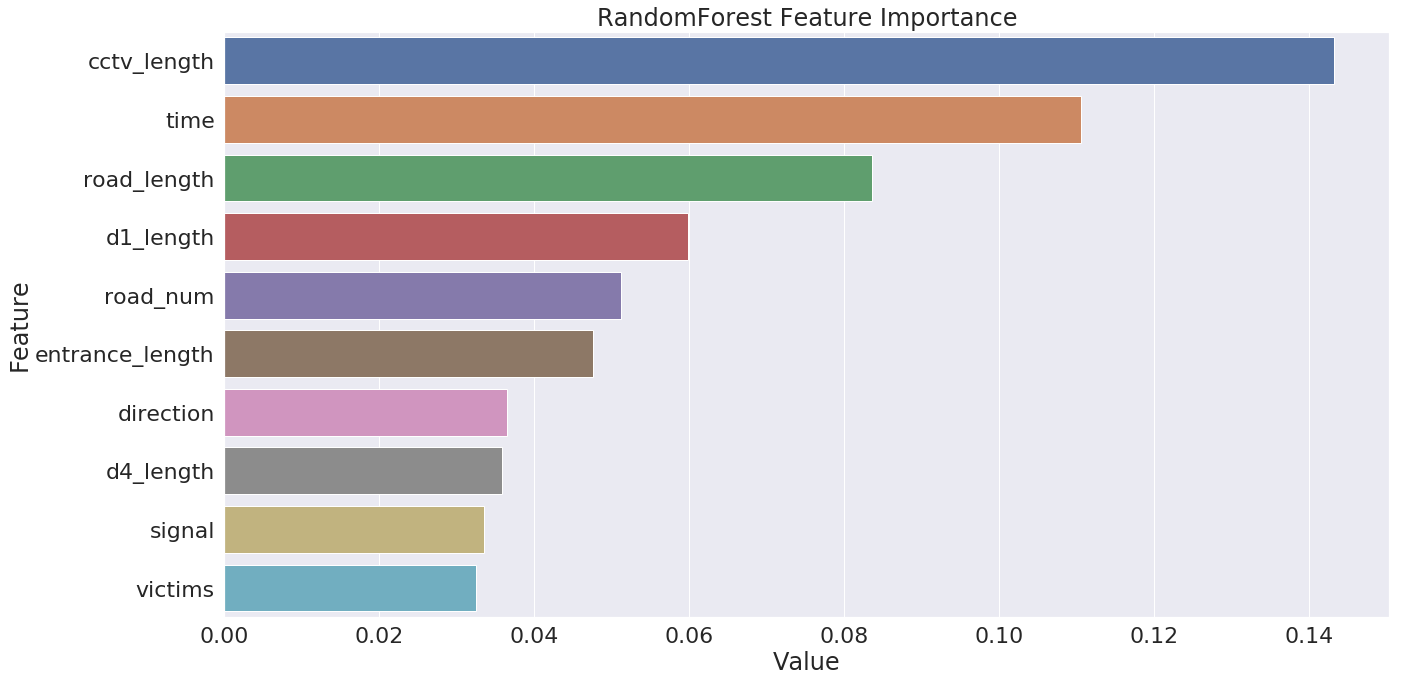

In [22]:
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_, X_train.columns)), columns=['Value','Feature'])

sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
plt.title('RandomForest Feature Importance')
plt.tight_layout()
plt.show()